In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import *
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
# from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras import backend 
from tensorflow.keras import utils

from keras_nlp.layers import SinePositionEncoding

import pydot

from funkcije import *

2023-09-18 18:08:08.539658: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 18:08:08.566934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 18:08:08.976889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


/home/ivan/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


U fajlu funkcije.py smo implementirali mnoge funkcije za pretprocesiranje i neke druge korisne stvari koje cemo da koristimo u vise notebooka.

Inicijalizujemo callback koji cemo da koristimo pri svakom treniranju modela. Naime, svaki model treniramo do trenutka dok performanse na validacionom skupu ne opadne.

In [2]:
#checkpoint = ModelCheckpoint('model_weights_{epoch}.h5', save_best_only=False, save_weights_only=True, monitor='val_loss', mode='min')
#Ckeckpoint se vise ne koristi
early_stopping = EarlyStopping(patience = 10, restore_best_weights = True, monitor = 'val_loss', mode = 'min', verbose = 1)

embedding_size = 300

### Model

In [3]:
class Transformer_Translation_Model(Model):
    def __init__(self, num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix, latent_dim = 512, dropout_rate = 0.5, custom_dropout_rate = 0.05):
        super(Transformer_Translation_Model, self).__init__()
        
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.custom_dropout_rate = custom_dropout_rate
        self.num_input_words = num_input_words
        self.num_target_words = num_target_words
        self.input_embedding_matrix = input_embedding_matrix
        self.target_embedding_matrix = target_embedding_matrix
        self.embedding_size = 300
        self.input_pad_len = 80
        self.target_pad_len = 60
        
        encoder_inputs = Input(shape=(self.input_pad_len,))
        x = CustomDropout(1.0, custom_dropout_rate)(encoder_inputs)
        # x = PositionalEmbedding(input_pad_len, num_input_words + 1, embedding_size)(encoder_inputs)
        encoder_embedding = Embedding(input_dim = num_input_words + 1, output_dim = embedding_size, mask_zero = True, weights = [input_embedding_matrix], trainable = False)(x)
        encoder_pos_encoding = SinePositionEncoding()(encoder_embedding)
        x = encoder_embedding + encoder_pos_encoding
        # encoder_outputs = TransformerEncoder(embedding_size, latent_dim, num_heads)(x)
        for i in range(num_transformer_layers):
            xt = MultiHeadAttention(num_heads=num_heads, key_dim=self.embedding_size)(x, x, x)
            x = LayerNormalization()(x + xt)
            xt = Dense(self.latent_dim, activation="relu") (x)
            xt = Dense(self.embedding_size) (xt)
            x = LayerNormalization() (x + xt)
        encoder_outputs = x
        self.encoder = keras.Model(encoder_inputs, encoder_outputs)
        
        decoder_inputs = Input(shape=(self.target_pad_len,))
        encoded_seq_inputs = Input(shape=(self.input_pad_len, self.embedding_size))
        # x = PositionalEmbedding(target_pad_len, num_target_words + 1, embedding_size)(decoder_inputs)
        decoder_embedding = Embedding(input_dim = num_input_words + 1, output_dim = self.embedding_size, mask_zero = True, trainable = True)(decoder_inputs)
        decoder_pos_encoding = SinePositionEncoding()(decoder_embedding)
        x = decoder_embedding + decoder_pos_encoding
        # x = TransformerDecoder(embedding_size, latent_dim, num_heads)(x, encoded_seq_inputs)
        for i in range(num_transformer_layers):
            causal_mask = self.get_causal_attention_mask(x)
            xt = MultiHeadAttention(num_heads=num_heads, key_dim=self.embedding_size) (x, x, x, attention_mask=causal_mask)
            x = LayerNormalization() (x + xt)
            xt = MultiHeadAttention(num_heads=num_heads, key_dim=self.embedding_size) (x, encoded_seq_inputs, encoded_seq_inputs)
            x = LayerNormalization() (x + xt)
            xt = Dense(latent_dim, activation="relu") (x)
            xt = Dense(self.embedding_size) (xt)
            x = LayerNormalization() (x + xt)
        x = layers.Dropout(self.dropout_rate)(x)
        decoder_outputs = layers.Dense(num_target_words + 1, activation="softmax")(x)
        self.decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
        
        decoder_outputs = self.decoder([decoder_inputs, encoder_outputs])
        self.transformer = keras.Model(
            [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
        )
#         print(self.transformer.summary(expand_nested=True))
#         utils.plot_model(self.transformer, show_shapes=True, expand_nested=True)
        
    def call(self, x):
        return self.transformer([x[0], x[1]])
        
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    def translate(self, encoder_input, decoder_input):
        decoder_state = self.encoder.predict(encoder_input, verbose = 0)
        data_size = encoder_input.shape[0]
        decoder_output = np.zeros((data_size, self.target_pad_len))
        decoder_output[:, 0] = decoder_input[:, 0]
        for i in range(1,self.target_pad_len - 1):
            decoder_output_temp = self.decoder.predict([decoder_output, decoder_state], verbose = 0)
            next_words = np.argmax(decoder_output_temp, axis = -1)
            decoder_output[:, i] = next_words[:,i-1].reshape((data_size,))    
#         output_sentences = [' '.join(inverted_target_word_index[num] for num in output_sentence[1:]) for output_sentence in decoder_output]
#         output_sentences = [output_sentence.split('<End>',1)[0].replace(' - ','-') for output_sentence in output_sentences]

        return decoder_output

## Pomocne funkcije

Funkcija train_and_evaluate istrenira model na train_data i evaluira ga na val_data. Kao mere za evaluaciju pamti Word Error Rate, BLEU 1-4 (smoothovan). Smoothovan BLEU se pokazao kao bolji u slucajevima kada recenicu imaju mali broj reci, sto je slucaj sa glossovanim recenicama.

Takodje cuva dostignut val_loss, kao i broj epoha do konvergencije.

Funkcija takodje daje mogucnost treniranja Embedding slojeva sa razlicitim learning_rate-om od ostalih slojeva. Ideja iza ovoga je da, posto su pocetne vrednosti Embedding slojeva pretrenirane, ima smisla da se taj sloj sporije trenira od ostalih.

In [4]:
#Trenira model na train_data i evaluira ga na val_data
#Embedding learning rate je poseban learning_rate koji se koristi u embedding slojevima, iz razloga sto oni vec imaju pretrenirane podatke za pocetne vrednosti
#Model se trenira dok val_loss ne krene da raste, i cuva tezine epohe koja ima najbolji val_loss
#Koristi se u cv_evaluate, napravio funkciju jer inace dolazi do prekoracenje GPU RAMa, neko je napisao da je do unakrsne validacije
def train_and_evaluate(train_data, val_data, epochs = 200, batch_size = 128, learning_rate = 0.001, latent_dim = 256, dropout_rate = 0.5, embedding_learning_rate = 0.001):
     
     input_texts, target_texts = clean_texts(train_data.iloc[:,1], train_data.iloc[:,0])
     input_word_index, target_word_index, max_input_seq_len, max_target_seq_len = analyse_texts(input_texts, target_texts)
     input_pad_len = 80
     target_pad_len = 60
     num_input_words = len(input_word_index) - 1
     num_target_words = len(target_word_index) - 1
     #print(num_input_words)
     inverted_input_word_index = {value: key for key,value in input_word_index.items()}
     inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}
     #print(len(inverted_input_word_index))
     input_embedding_matrix, target_embedding_matrix = load_embedding_data_get_matrices(inverted_input_word_index, inverted_target_word_index)
     print('Embeddings loaded.')
     encoder_input_data, decoder_input_data, decoder_output_data = create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len)
     #print(input_embedding_matrix.shape)
     
     input_texts_val, target_texts_val = clean_texts(val_data.iloc[:,1], val_data.iloc[:,0])
     encoder_input_data_val, decoder_input_data_val, decoder_output_data_val = create_model_data(input_texts_val, target_texts_val, input_word_index, target_word_index, input_pad_len, target_pad_len)
     
     #print('Data preprocessed.')
     model_transformer = Transformer_Translation_Model(num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix, latent_dim = latent_dim, dropout_rate = dropout_rate)
     #print('Model loaded.')
     other_layers = model_transformer.layers #Mora da se prilagodi za transformer
     embedding_layers = [] #Paznja! Mora se prilagoditi svaki put kad se model menja

     optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers = [(Adam(learning_rate), other_layers), (Adam(embedding_learning_rate), embedding_layers)])
     model_transformer.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
     #print('Model compiled.')
     history = model_transformer.fit([encoder_input_data, decoder_input_data], decoder_output_data, validation_data = ([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val), epochs = epochs, batch_size = batch_size, callbacks = [early_stopping], verbose = 1)
     #print('Model fit.')
     best_epoch = np.argmin(history.history['val_loss']) + 1
     
     #print('Best epoch: ', best_epoch)
     best_loss = np.min(history.history['val_loss'])
     #print('Best loss:', best_loss)
     #print(model_transformer.evaluate([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val))
     K.clear_session()
     wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = evaluate(model_transformer, input_texts_val, target_texts_val, input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
     K.clear_session()
     return best_epoch, best_loss, wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1
 

Funkcija cv_evaluate trenira po model za svaki fold, racuna odgovarajuce metrike.

Funkcija vraca podatke iz svake instance modela, odnosno folda, da bi se dalje procesirale

In [5]:
#Trenira po model za svaki fold, racuna WER, smooth BLEU(1,2,3,4), kao i val_loss i broj epoha do konvergencije
#Vraca podatke iz svake instance modela, odnosno za svaki fold, da bi se dalje procesirale
def cv_evaluate(train_val_data = None, df_folds = None, folds = 5, epochs = 200, batch_size = 32, learning_rate = 0.001, latent_dim = 256, dropout_rate = 0.5, embedding_learning_rate = None):
    if embedding_learning_rate == None:
        embedding_learning_rate = learning_rate
    if df_folds == None:
        df_np = train_val_data.to_numpy()
        np.random.shuffle(df_np)
        total_size = df_np.shape[0]
        fold_size = total_size/folds
        df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    #input_word_embeddings, target_word_embeddings = load_embedding_data() #Doslo je do prekoracenje memorije
    losses = []
    best_epochs = []
    wers = []
    smooth_bleu1s = []
    smooth_bleu2s = []
    smooth_bleu3s = []
    smooth_bleu4s = []
    for i in range(folds):
        train_folds = [fold for j, fold in enumerate(df_folds) if j!=i]
        train_folds_pd = [pd.DataFrame(data = fold) for fold in train_folds]
        train_data = pd.concat(train_folds_pd)
        val_data = pd.DataFrame(df_folds[i])
        print('Current Latent Dim:', latent_dim)
        print('Current Dropout Rate: ', dropout_rate)
        print('Current Fold: {}/{}'.format(i+1, folds))
        print('Current Learning Rate: ', learning_rate)
        print('Current Learning Rate Multiplier: ', embedding_learning_rate/learning_rate)
        
        best_epoch, best_loss, wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = train_and_evaluate(train_data, val_data, epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, latent_dim = latent_dim, dropout_rate = dropout_rate, embedding_learning_rate = embedding_learning_rate)
        best_epochs.append(best_epoch)
        losses.append(best_loss)
        wers.append(wer)
        smooth_bleu4s.append(smooth_bleu4)
        smooth_bleu3s.append(smooth_bleu3)
        smooth_bleu2s.append(smooth_bleu2)
        smooth_bleu1s.append(smooth_bleu1)
    return best_epochs, losses, wers, smooth_bleu4s, smooth_bleu3s, smooth_bleu2s, smooth_bleu1s


Funkcija grid_search_cv evaluira model za razlicite vrednosti parametara latent_dim i dropout_rate. Rezultate vraca u obliku dictionary-ja kojim je moguce pristupiti svim izracunatim metrikama.

In [6]:
#Evaluira modele za razlicite vrednosti latent_dim i dropout_rate
#U 3d matrici cuva rezultate, treca dimenzija predstavlja vrednosti za razlicite foldove, uprosecavanjem se dobija zeljena metrika
#Isto cuva i broj epoha do konvergencije 
def cv_grid_search(df, dropout_rates, latent_dims, epochs = 200, learning_rate = 0.0002, folds = 5):
    df_np = df.to_numpy()
    np.random.shuffle(df_np)
    total_size = df_np.shape[0]
    fold_size = total_size/folds
    df_folds = [df_np[int(i*fold_size):int((i+1)*fold_size),] for i in range(folds)]
    
    loss_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    epoch_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    wer_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu4_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu3_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu2_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    smooth_bleu1_matrix = np.zeros((len(latent_dims),len(dropout_rates), folds))
    for i in range(len(latent_dims)):
        for j in range(len(dropout_rates)):
            best_epochs, losses, wers, smooth_bleu4s, smooth_bleu3s, smooth_bleu2s, smooth_bleu1s = cv_evaluate(df_folds = df_folds, folds = folds, epochs = epochs, learning_rate = learning_rate, latent_dim = latent_dims[i], dropout_rate = dropout_rates[j])
            print(losses)
            print(best_epochs)
            loss_matrix[i,j,:] = losses
            epoch_matrix[i,j,:] = best_epochs
            wer_matrix[i,j,:] = wers
            smooth_bleu4_matrix[i,j,:] = smooth_bleu4s
            smooth_bleu3_matrix[i,j,:] = smooth_bleu3s
            smooth_bleu2_matrix[i,j,:] = smooth_bleu2s
            smooth_bleu1_matrix[i,j,:] = smooth_bleu1s
    #Pakuju se rezultati u dictionary radi intuitivnijeg poziva funkcije
    metrics_dict = {'loss': loss_matrix, 'epoch': epoch_matrix, 'wer': wer_matrix, 'smooth_bleu4': smooth_bleu4_matrix, 'smooth_bleu3': smooth_bleu3_matrix, 'smooth_bleu2': smooth_bleu2_matrix, 'smooth_bleu1': smooth_bleu1_matrix }
    return metrics_dict

# Glavni program

Za pocetak samo ucitavamo podatke i spajamo trening i validacioni skup u jedan koji cemo koristiti za unakrsnu validaciju. Kasnije cemo model evaluirati na test skupu. Ne radimo ugnjezdenu unakrsnu validaciju jer bi predugo trajalo.

In [7]:
df_train = pd.read_csv('data/PHOENIX-2014-T.train.corpus.csv', sep='|')
df_train = df_train.drop(columns=['name','video','start','end','speaker'])
train_size = df_train.shape[0]
#Orth je glossovana recenica, translation je originalna engleska

df_val = pd.read_csv('data/PHOENIX-2014-T.dev.corpus.csv', sep = '|')
df_val.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
val_size = df_val.shape[0]

df_test = pd.read_csv('data/PHOENIX-2014-T.test.corpus.csv', sep = '|')
df_test.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
test_size = df_test.shape[0]

df_train_val = pd.concat([df_train, df_val])
df_full = pd.concat([df_train_val, df_test])

### Grid Search

Hiperparametri koje cemo da optimizujemo su dropout_rate i latent_dim. Learning rate fiksiramo na vrednost koja nam je iz testiranja dobro radila.

In [8]:
#Hiperparametri za optimizaciju: dropout rate i latentna dimenzija
dropout_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
latent_dims = [256, 512, 1024] #Treba probati i vecu latentnu dimenziju i dropout rate, posto optimalna vrednost ispada najveca
learning_rate = 0.0002
folds = 5

num_heads = 8
num_transformer_layers = 1

Radimo grid search sa unakrsnom validacijom, metrika koju optimizujemo je smooth BLEU4

Current Latent Dim: 256
Current Dropout Rate:  0.5
Current Fold: 1/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.


2023-09-18 18:08:46.612916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-18 18:08:46.627623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-18 18:08:46.627752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/200


2023-09-18 18:08:49.919171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-18 18:08:49.963827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-09-18 18:08:49.984889: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b0edfc5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-18 18:08:49.984904: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-09-18 18:08:49.987622: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-18 18:08:50.074710: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

191/191 [==============================] - 13s 42ms/step - loss: 0.9156 - acc: 0.8518 - val_loss: 0.7389 - val_acc: 0.8672
Epoch 2/200
191/191 [==============================] - 4s 21ms/step - loss: 0.7352 - acc: 0.8669 - val_loss: 0.6659 - val_acc: 0.8722
Epoch 3/200
191/191 [==============================] - 4s 18ms/step - loss: 0.6630 - acc: 0.8743 - val_loss: 0.6070 - val_acc: 0.8820
Epoch 4/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6044 - acc: 0.8826 - val_loss: 0.5558 - val_acc: 0.8894
Epoch 5/200
191/191 [==============================] - 3s 18ms/step - loss: 0.5616 - acc: 0.8885 - val_loss: 0.5294 - val_acc: 0.8923
Epoch 6/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5318 - acc: 0.8926 - val_loss: 0.5045 - val_acc: 0.8969
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5087 - acc: 0.8960 - val_loss: 0.4934 - val_acc: 0.8989
Epoch 8/200
191/191 [==============================] - 4s 20ms/step - los

191/191 [==============================] - 3s 16ms/step - loss: 0.3138 - acc: 0.9252 - val_loss: 0.4178 - val_acc: 0.9136
Epoch 27/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3085 - acc: 0.9262 - val_loss: 0.4188 - val_acc: 0.9130
Epoch 28/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3000 - acc: 0.9277 - val_loss: 0.4290 - val_acc: 0.9117
Epoch 29/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2953 - acc: 0.9284 - val_loss: 0.4281 - val_acc: 0.9129
Epoch 30/200
191/191 [==============================] - 3s 16ms/step - loss: 0.2889 - acc: 0.9296 - val_loss: 0.4294 - val_acc: 0.9128
Epoch 31/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2820 - acc: 0.9307 - val_loss: 0.4289 - val_acc: 0.9128
Epoch 32/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2785 - acc: 0.9316 - val_loss: 0.4293 - val_acc: 0.9125
Epoch 33/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.3917 - acc: 0.9124 - val_loss: 0.4053 - val_acc: 0.9140
Epoch 18/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3857 - acc: 0.9134 - val_loss: 0.4035 - val_acc: 0.9130
Epoch 19/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3755 - acc: 0.9152 - val_loss: 0.3995 - val_acc: 0.9151
Epoch 20/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3686 - acc: 0.9164 - val_loss: 0.4000 - val_acc: 0.9155
Epoch 21/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3605 - acc: 0.9174 - val_loss: 0.3963 - val_acc: 0.9160
Epoch 22/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3532 - acc: 0.9185 - val_loss: 0.3983 - val_acc: 0.9175
Epoch 23/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3469 - acc: 0.9195 - val_loss: 0.4022 - val_acc: 0.9163
Epoch 24/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5269 - acc: 0.8940 - val_loss: 0.5005 - val_acc: 0.8976
Epoch 8/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5083 - acc: 0.8969 - val_loss: 0.4828 - val_acc: 0.9006
Epoch 9/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4913 - acc: 0.8989 - val_loss: 0.4793 - val_acc: 0.9012
Epoch 10/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4784 - acc: 0.9004 - val_loss: 0.4682 - val_acc: 0.9021
Epoch 11/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4663 - acc: 0.9025 - val_loss: 0.4547 - val_acc: 0.9047
Epoch 12/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4567 - acc: 0.9039 - val_loss: 0.4616 - val_acc: 0.9033
Epoch 13/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4460 - acc: 0.9053 - val_loss: 0.4417 - val_acc: 0.9069
Epoch 14/200
191/191 [==============================] - 3s 17ms/step -

191/191 [==============================] - 3s 17ms/step - loss: 0.3488 - acc: 0.9201 - val_loss: 0.4191 - val_acc: 0.9122
Epoch 30/200
191/191 [==============================] - 3s 18ms/step - loss: 0.3422 - acc: 0.9215 - val_loss: 0.4215 - val_acc: 0.9121
Epoch 31/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3379 - acc: 0.9221 - val_loss: 0.4222 - val_acc: 0.9134
Epoch 32/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3325 - acc: 0.9228 - val_loss: 0.4194 - val_acc: 0.9138
Epoch 33/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3260 - acc: 0.9245 - val_loss: 0.4191 - val_acc: 0.9134
Epoch 34/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3228 - acc: 0.9246 - val_loss: 0.4208 - val_acc: 0.9131
Epoch 35/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3184 - acc: 0.9255 - val_loss: 0.4318 - val_acc: 0.9126
Epoch 36/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5014 - acc: 0.8967 - val_loss: 0.4611 - val_acc: 0.9032
Epoch 10/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4880 - acc: 0.8987 - val_loss: 0.4604 - val_acc: 0.9041
Epoch 11/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4762 - acc: 0.9003 - val_loss: 0.4445 - val_acc: 0.9070
Epoch 12/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4642 - acc: 0.9022 - val_loss: 0.4469 - val_acc: 0.9052
Epoch 13/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4559 - acc: 0.9033 - val_loss: 0.4332 - val_acc: 0.9085
Epoch 14/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4453 - acc: 0.9049 - val_loss: 0.4306 - val_acc: 0.9098
Epoch 15/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4365 - acc: 0.9065 - val_loss: 0.4216 - val_acc: 0.9104
Epoch 16/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 16ms/step - loss: 0.3760 - acc: 0.9153 - val_loss: 0.4288 - val_acc: 0.9102
Epoch 32/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3700 - acc: 0.9166 - val_loss: 0.4296 - val_acc: 0.9102
Epoch 33/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3656 - acc: 0.9171 - val_loss: 0.4260 - val_acc: 0.9103
Epoch 34/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3616 - acc: 0.9182 - val_loss: 0.4251 - val_acc: 0.9115
Epoch 35/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3584 - acc: 0.9182 - val_loss: 0.4281 - val_acc: 0.9118
Epoch 36/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3519 - acc: 0.9196 - val_loss: 0.4244 - val_acc: 0.9113
Epoch 37/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3476 - acc: 0.9203 - val_loss: 0.4276 - val_acc: 0.9119
Epoch 38/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.3472 - acc: 0.9210 - val_loss: 0.4396 - val_acc: 0.9119
Epoch 43/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3441 - acc: 0.9213 - val_loss: 0.4306 - val_acc: 0.9120
Epoch 44/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3414 - acc: 0.9219 - val_loss: 0.4291 - val_acc: 0.9127
Epoch 45/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3368 - acc: 0.9228 - val_loss: 0.4306 - val_acc: 0.9124
Epoch 46/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3335 - acc: 0.9233 - val_loss: 0.4361 - val_acc: 0.9116
Epoch 47/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3297 - acc: 0.9239 - val_loss: 0.4336 - val_acc: 0.9120
Epoch 48/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3283 - acc: 0.9243 - val_loss: 0.4359 - val_acc: 0.9118
Epoch 48: early stopping
Current Latent Dim: 256
Current Dropout Rat

191/191 [==============================] - 3s 17ms/step - loss: 0.3043 - acc: 0.9294 - val_loss: 0.4380 - val_acc: 0.9123
Epoch 53/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3022 - acc: 0.9294 - val_loss: 0.4390 - val_acc: 0.9121
Epoch 53: early stopping
Current Latent Dim: 256
Current Dropout Rate:  0.7
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
191/191 [==============================] - 12s 35ms/step - loss: 0.9800 - acc: 0.8495 - val_loss: 0.7520 - val_acc: 0.8623
Epoch 2/200
191/191 [==============================] - 4s 19ms/step - loss: 0.7660 - acc: 0.8659 - val_loss: 0.6887 - val_acc: 0.8685
Epoch 3/200
191/191 [==============================] - 3s 17ms/step - loss: 0.7056 - acc: 0.8696 - val_loss: 0.6548 - val_acc: 0.8713
Epoch 4/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6612 - acc: 0.8746 - val_loss: 0.6093 - val_acc: 0.8790
Epoch 5/200
191/191 [==

191/191 [==============================] - 3s 18ms/step - loss: 0.7217 - acc: 0.8676 - val_loss: 0.6404 - val_acc: 0.8772
Epoch 4/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6781 - acc: 0.8719 - val_loss: 0.5986 - val_acc: 0.8831
Epoch 5/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6370 - acc: 0.8781 - val_loss: 0.5601 - val_acc: 0.8883
Epoch 6/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6032 - acc: 0.8823 - val_loss: 0.5321 - val_acc: 0.8921
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5794 - acc: 0.8855 - val_loss: 0.5167 - val_acc: 0.8952
Epoch 8/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5560 - acc: 0.8887 - val_loss: 0.4999 - val_acc: 0.8982
Epoch 9/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5424 - acc: 0.8912 - val_loss: 0.4915 - val_acc: 0.8988
Epoch 10/200
191/191 [==============================] - 3s 17ms/step - los

191/191 [==============================] - 3s 17ms/step - loss: 0.4572 - acc: 0.9037 - val_loss: 0.4558 - val_acc: 0.9049
Epoch 17/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4513 - acc: 0.9050 - val_loss: 0.4560 - val_acc: 0.9059
Epoch 18/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4451 - acc: 0.9054 - val_loss: 0.4542 - val_acc: 0.9057
Epoch 19/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4365 - acc: 0.9070 - val_loss: 0.4518 - val_acc: 0.9048
Epoch 20/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4314 - acc: 0.9076 - val_loss: 0.4454 - val_acc: 0.9069
Epoch 21/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4260 - acc: 0.9086 - val_loss: 0.4474 - val_acc: 0.9066
Epoch 22/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4216 - acc: 0.9090 - val_loss: 0.4443 - val_acc: 0.9059
Epoch 23/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.4115 - acc: 0.9117 - val_loss: 0.4314 - val_acc: 0.9087
Epoch 35/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4103 - acc: 0.9122 - val_loss: 0.4297 - val_acc: 0.9094
Epoch 36/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4056 - acc: 0.9128 - val_loss: 0.4308 - val_acc: 0.9100
Epoch 37/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4032 - acc: 0.9135 - val_loss: 0.4380 - val_acc: 0.9100
Epoch 38/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3987 - acc: 0.9142 - val_loss: 0.4335 - val_acc: 0.9106
Epoch 39/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3967 - acc: 0.9148 - val_loss: 0.4357 - val_acc: 0.9101
Epoch 40/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3944 - acc: 0.9146 - val_loss: 0.4310 - val_acc: 0.9105
Epoch 41/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 16ms/step - loss: 0.3802 - acc: 0.9175 - val_loss: 0.4350 - val_acc: 0.9097
Epoch 48/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3796 - acc: 0.9178 - val_loss: 0.4352 - val_acc: 0.9097
Epoch 49/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3761 - acc: 0.9182 - val_loss: 0.4395 - val_acc: 0.9088
Epoch 50/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3743 - acc: 0.9188 - val_loss: 0.4368 - val_acc: 0.9104
Epoch 51/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3727 - acc: 0.9189 - val_loss: 0.4324 - val_acc: 0.9100
Epoch 52/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3702 - acc: 0.9195 - val_loss: 0.4339 - val_acc: 0.9109
Epoch 53/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3693 - acc: 0.9198 - val_loss: 0.4319 - val_acc: 0.9109
Epoch 54/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.4116 - acc: 0.9123 - val_loss: 0.4457 - val_acc: 0.9067
Epoch 43/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4089 - acc: 0.9127 - val_loss: 0.4467 - val_acc: 0.9070
Epoch 44/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4070 - acc: 0.9129 - val_loss: 0.4451 - val_acc: 0.9074
Epoch 45/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4049 - acc: 0.9134 - val_loss: 0.4407 - val_acc: 0.9079
Epoch 46/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4015 - acc: 0.9141 - val_loss: 0.4392 - val_acc: 0.9083
Epoch 47/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3992 - acc: 0.9144 - val_loss: 0.4397 - val_acc: 0.9088
Epoch 48/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3985 - acc: 0.9146 - val_loss: 0.4434 - val_acc: 0.9083
Epoch 49/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 16ms/step - loss: 0.4223 - acc: 0.9098 - val_loss: 0.4207 - val_acc: 0.9113
Epoch 37/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4202 - acc: 0.9102 - val_loss: 0.4245 - val_acc: 0.9107
Epoch 38/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4188 - acc: 0.9105 - val_loss: 0.4196 - val_acc: 0.9116
Epoch 39/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4151 - acc: 0.9111 - val_loss: 0.4214 - val_acc: 0.9120
Epoch 40/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4120 - acc: 0.9114 - val_loss: 0.4187 - val_acc: 0.9125
Epoch 41/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4077 - acc: 0.9123 - val_loss: 0.4198 - val_acc: 0.9123
Epoch 42/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4080 - acc: 0.9122 - val_loss: 0.4180 - val_acc: 0.9129
Epoch 43/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.4542 - acc: 0.9045 - val_loss: 0.4542 - val_acc: 0.9055
Epoch 30/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4461 - acc: 0.9061 - val_loss: 0.4489 - val_acc: 0.9058
Epoch 31/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4391 - acc: 0.9069 - val_loss: 0.4493 - val_acc: 0.9063
Epoch 32/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4366 - acc: 0.9073 - val_loss: 0.4467 - val_acc: 0.9064
Epoch 33/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4333 - acc: 0.9083 - val_loss: 0.4433 - val_acc: 0.9076
Epoch 34/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4309 - acc: 0.9086 - val_loss: 0.4495 - val_acc: 0.9066
Epoch 35/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4276 - acc: 0.9090 - val_loss: 0.4466 - val_acc: 0.9075
Epoch 36/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5307 - acc: 0.8942 - val_loss: 0.4998 - val_acc: 0.8975
Epoch 25/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5292 - acc: 0.8944 - val_loss: 0.4989 - val_acc: 0.8983
Epoch 26/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5246 - acc: 0.8952 - val_loss: 0.4959 - val_acc: 0.8985
Epoch 27/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5219 - acc: 0.8953 - val_loss: 0.5084 - val_acc: 0.8947
Epoch 28/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5187 - acc: 0.8962 - val_loss: 0.4948 - val_acc: 0.8987
Epoch 29/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5174 - acc: 0.8961 - val_loss: 0.4931 - val_acc: 0.8994
Epoch 30/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5131 - acc: 0.8969 - val_loss: 0.4934 - val_acc: 0.8981
Epoch 31/200
191/191 [==============================] - 3s 16ms/step

Epoch 85/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4329 - acc: 0.9098 - val_loss: 0.4633 - val_acc: 0.9070
Epoch 86/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4326 - acc: 0.9100 - val_loss: 0.4647 - val_acc: 0.9060
Epoch 87/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4303 - acc: 0.9102 - val_loss: 0.4678 - val_acc: 0.9070
Epoch 88/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4312 - acc: 0.9101 - val_loss: 0.4643 - val_acc: 0.9057
Epoch 89/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4297 - acc: 0.9107 - val_loss: 0.4622 - val_acc: 0.9067
Epoch 90/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4287 - acc: 0.9104 - val_loss: 0.4638 - val_acc: 0.9067
Epoch 91/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4267 - acc: 0.9109 - val_loss: 0.4669 - val_acc: 0.9069
Epoch 91: early stopping
Current Latent Dim: 256
Curren

191/191 [==============================] - 3s 16ms/step - loss: 0.4648 - acc: 0.9053 - val_loss: 0.4711 - val_acc: 0.9036
Epoch 53/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4665 - acc: 0.9049 - val_loss: 0.4714 - val_acc: 0.9032
Epoch 54/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4621 - acc: 0.9059 - val_loss: 0.4722 - val_acc: 0.9038
Epoch 55/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4617 - acc: 0.9058 - val_loss: 0.4718 - val_acc: 0.9045
Epoch 56/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4600 - acc: 0.9061 - val_loss: 0.4729 - val_acc: 0.9039
Epoch 57/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4579 - acc: 0.9064 - val_loss: 0.4704 - val_acc: 0.9036
Epoch 58/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4571 - acc: 0.9064 - val_loss: 0.4707 - val_acc: 0.9036
Epoch 59/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5173 - acc: 0.8961 - val_loss: 0.5008 - val_acc: 0.8966
Epoch 42/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5044 - acc: 0.8981 - val_loss: 0.4933 - val_acc: 0.8975
Epoch 43/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4987 - acc: 0.8991 - val_loss: 0.5067 - val_acc: 0.8969
Epoch 44/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4985 - acc: 0.8990 - val_loss: 0.4924 - val_acc: 0.8982
Epoch 45/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4966 - acc: 0.8991 - val_loss: 0.5002 - val_acc: 0.8984
Epoch 46/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4949 - acc: 0.8995 - val_loss: 0.4884 - val_acc: 0.8985
Epoch 47/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4943 - acc: 0.8994 - val_loss: 0.4876 - val_acc: 0.8987
Epoch 48/200
191/191 [==============================] - 3s 16ms/step

Epoch 102/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4394 - acc: 0.9087 - val_loss: 0.4794 - val_acc: 0.9032
Epoch 103/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4344 - acc: 0.9095 - val_loss: 0.4724 - val_acc: 0.9045
Epoch 104/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4342 - acc: 0.9099 - val_loss: 0.4812 - val_acc: 0.9035
Epoch 105/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4345 - acc: 0.9093 - val_loss: 0.4737 - val_acc: 0.9041
Epoch 106/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4319 - acc: 0.9098 - val_loss: 0.4710 - val_acc: 0.9036
Epoch 107/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4311 - acc: 0.9100 - val_loss: 0.4710 - val_acc: 0.9033
Epoch 108/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4325 - acc: 0.9093 - val_loss: 0.4698 - val_acc: 0.9038
Epoch 109/200
191/191 [=========================

191/191 [==============================] - 3s 16ms/step - loss: 0.4856 - acc: 0.9005 - val_loss: 0.4578 - val_acc: 0.9059
Epoch 51/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4855 - acc: 0.9010 - val_loss: 0.4650 - val_acc: 0.9042
Epoch 52/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4875 - acc: 0.9006 - val_loss: 0.4612 - val_acc: 0.9054
Epoch 53/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4829 - acc: 0.9015 - val_loss: 0.4575 - val_acc: 0.9055
Epoch 54/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4846 - acc: 0.9007 - val_loss: 0.4578 - val_acc: 0.9064
Epoch 55/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4801 - acc: 0.9014 - val_loss: 0.4606 - val_acc: 0.9071
Epoch 56/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4787 - acc: 0.9015 - val_loss: 0.4572 - val_acc: 0.9065
Epoch 57/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 16ms/step - loss: 0.5475 - acc: 0.8917 - val_loss: 0.5160 - val_acc: 0.8949
Epoch 19/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5442 - acc: 0.8922 - val_loss: 0.5097 - val_acc: 0.8976
Epoch 20/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5380 - acc: 0.8929 - val_loss: 0.5073 - val_acc: 0.8968
Epoch 21/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5334 - acc: 0.8937 - val_loss: 0.5035 - val_acc: 0.8980
Epoch 22/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5308 - acc: 0.8943 - val_loss: 0.5081 - val_acc: 0.8970
Epoch 23/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5304 - acc: 0.8940 - val_loss: 0.5002 - val_acc: 0.8980
Epoch 24/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5222 - acc: 0.8953 - val_loss: 0.5099 - val_acc: 0.8967
Epoch 25/200
191/191 [==============================] - 3s 16ms/step

191/191 [==============================] - 3s 16ms/step - loss: 0.5203 - acc: 0.8942 - val_loss: 0.4999 - val_acc: 0.8957
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4976 - acc: 0.8975 - val_loss: 0.4816 - val_acc: 0.8993
Epoch 8/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4802 - acc: 0.8998 - val_loss: 0.4678 - val_acc: 0.9026
Epoch 9/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4645 - acc: 0.9019 - val_loss: 0.4601 - val_acc: 0.9039
Epoch 10/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4506 - acc: 0.9041 - val_loss: 0.4508 - val_acc: 0.9054
Epoch 11/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4385 - acc: 0.9059 - val_loss: 0.4443 - val_acc: 0.9068
Epoch 12/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4245 - acc: 0.9080 - val_loss: 0.4365 - val_acc: 0.9081
Epoch 13/200
191/191 [==============================] - 3s 16ms/step - 

191/191 [==============================] - 3s 17ms/step - loss: 0.2728 - acc: 0.9319 - val_loss: 0.4436 - val_acc: 0.9123
Epoch 35/200
191/191 [==============================] - 3s 16ms/step - loss: 0.2664 - acc: 0.9337 - val_loss: 0.4422 - val_acc: 0.9111
Epoch 36/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2622 - acc: 0.9341 - val_loss: 0.4499 - val_acc: 0.9128
Epoch 36: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.5
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
191/191 [==============================] - 11s 34ms/step - loss: 0.9105 - acc: 0.8525 - val_loss: 0.7387 - val_acc: 0.8643
Epoch 2/200
191/191 [==============================] - 4s 18ms/step - loss: 0.7232 - acc: 0.8683 - val_loss: 0.6578 - val_acc: 0.8724
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6526 - acc: 0.8758 - val_loss: 0.5955 - val_acc: 0.8822
Epoch 4/200
191/191 [=

191/191 [==============================] - 3s 17ms/step - loss: 0.3739 - acc: 0.9156 - val_loss: 0.4045 - val_acc: 0.9144
Epoch 20/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3670 - acc: 0.9166 - val_loss: 0.4005 - val_acc: 0.9147
Epoch 21/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3597 - acc: 0.9179 - val_loss: 0.4104 - val_acc: 0.9146
Epoch 22/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3509 - acc: 0.9192 - val_loss: 0.3943 - val_acc: 0.9163
Epoch 23/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3427 - acc: 0.9201 - val_loss: 0.3984 - val_acc: 0.9166
Epoch 24/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3350 - acc: 0.9214 - val_loss: 0.3983 - val_acc: 0.9161
Epoch 25/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3293 - acc: 0.9225 - val_loss: 0.4043 - val_acc: 0.9157
Epoch 26/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.6050 - acc: 0.8786 - val_loss: 0.4915 - val_acc: 0.8976
Epoch 10/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4920 - acc: 0.8981 - val_loss: 0.4691 - val_acc: 0.9022
Epoch 11/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4762 - acc: 0.9002 - val_loss: 0.4627 - val_acc: 0.9031
Epoch 12/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4639 - acc: 0.9019 - val_loss: 0.4606 - val_acc: 0.9035
Epoch 13/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4543 - acc: 0.9032 - val_loss: 0.4562 - val_acc: 0.9039
Epoch 14/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4449 - acc: 0.9047 - val_loss: 0.4487 - val_acc: 0.9052
Epoch 15/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4375 - acc: 0.9056 - val_loss: 0.4452 - val_acc: 0.9055
Epoch 16/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.3111 - acc: 0.9265 - val_loss: 0.4246 - val_acc: 0.9136
Epoch 32/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3073 - acc: 0.9271 - val_loss: 0.4278 - val_acc: 0.9134
Epoch 33/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3009 - acc: 0.9282 - val_loss: 0.4266 - val_acc: 0.9137
Epoch 34/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2966 - acc: 0.9292 - val_loss: 0.4286 - val_acc: 0.9140
Epoch 35/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2920 - acc: 0.9301 - val_loss: 0.4339 - val_acc: 0.9135
Epoch 35: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.6
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
191/191 [==============================] - 11s 35ms/step - loss: 0.9273 - acc: 0.8514 - val_loss: 0.7421 - val_acc: 0.8646
Epoch 2/200
191/191 

191/191 [==============================] - 3s 17ms/step - loss: 0.5767 - acc: 0.8836 - val_loss: 0.4636 - val_acc: 0.9029
Epoch 16/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4788 - acc: 0.8996 - val_loss: 0.4348 - val_acc: 0.9077
Epoch 17/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4539 - acc: 0.9035 - val_loss: 0.4272 - val_acc: 0.9090
Epoch 18/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4404 - acc: 0.9052 - val_loss: 0.4222 - val_acc: 0.9100
Epoch 19/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4292 - acc: 0.9070 - val_loss: 0.4186 - val_acc: 0.9110
Epoch 20/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4227 - acc: 0.9083 - val_loss: 0.4156 - val_acc: 0.9113
Epoch 21/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4146 - acc: 0.9091 - val_loss: 0.4175 - val_acc: 0.9103
Epoch 22/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.3180 - acc: 0.9253 - val_loss: 0.4308 - val_acc: 0.9125
Epoch 29/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3150 - acc: 0.9263 - val_loss: 0.4335 - val_acc: 0.9126
Epoch 30/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3099 - acc: 0.9268 - val_loss: 0.4285 - val_acc: 0.9131
Epoch 31/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3025 - acc: 0.9282 - val_loss: 0.4283 - val_acc: 0.9135
Epoch 32/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2983 - acc: 0.9291 - val_loss: 0.4333 - val_acc: 0.9127
Epoch 33/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2933 - acc: 0.9294 - val_loss: 0.4381 - val_acc: 0.9127
Epoch 34/200
191/191 [==============================] - 3s 17ms/step - loss: 0.2853 - acc: 0.9313 - val_loss: 0.4367 - val_acc: 0.9122
Epoch 35/200
191/191 [==============================] - 3s 17ms/step

Epoch 47: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.7
Current Fold: 2/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
191/191 [==============================] - 12s 36ms/step - loss: 0.9889 - acc: 0.8498 - val_loss: 0.7458 - val_acc: 0.8647
Epoch 2/200
191/191 [==============================] - 4s 19ms/step - loss: 0.7663 - acc: 0.8654 - val_loss: 0.6912 - val_acc: 0.8683
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.7023 - acc: 0.8700 - val_loss: 0.6431 - val_acc: 0.8745
Epoch 4/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6547 - acc: 0.8758 - val_loss: 0.5979 - val_acc: 0.8816
Epoch 5/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6096 - acc: 0.8825 - val_loss: 0.5604 - val_acc: 0.8868
Epoch 6/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5738 - acc: 0.8877 - val_loss: 0.5314 - val_acc: 0.8924
Epoch 7/200


191/191 [==============================] - 3s 17ms/step - loss: 0.4389 - acc: 0.9068 - val_loss: 0.4475 - val_acc: 0.9046
Epoch 19/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4321 - acc: 0.9077 - val_loss: 0.4476 - val_acc: 0.9049
Epoch 20/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4242 - acc: 0.9091 - val_loss: 0.4480 - val_acc: 0.9054
Epoch 21/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4200 - acc: 0.9094 - val_loss: 0.4403 - val_acc: 0.9056
Epoch 22/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4163 - acc: 0.9101 - val_loss: 0.4385 - val_acc: 0.9057
Epoch 23/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4094 - acc: 0.9111 - val_loss: 0.4392 - val_acc: 0.9055
Epoch 24/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4032 - acc: 0.9120 - val_loss: 0.4327 - val_acc: 0.9080
Epoch 25/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.3794 - acc: 0.9158 - val_loss: 0.4120 - val_acc: 0.9135
Epoch 34/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3720 - acc: 0.9173 - val_loss: 0.4121 - val_acc: 0.9136
Epoch 35/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3701 - acc: 0.9178 - val_loss: 0.4074 - val_acc: 0.9152
Epoch 36/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3645 - acc: 0.9183 - val_loss: 0.4072 - val_acc: 0.9146
Epoch 37/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3598 - acc: 0.9192 - val_loss: 0.4145 - val_acc: 0.9138
Epoch 38/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3556 - acc: 0.9198 - val_loss: 0.4067 - val_acc: 0.9154
Epoch 39/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3522 - acc: 0.9203 - val_loss: 0.4110 - val_acc: 0.9149
Epoch 40/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 11s 34ms/step - loss: 1.0408 - acc: 0.8478 - val_loss: 0.7475 - val_acc: 0.8654
Epoch 2/200
191/191 [==============================] - 3s 18ms/step - loss: 0.7975 - acc: 0.8645 - val_loss: 0.7113 - val_acc: 0.8669
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.7392 - acc: 0.8672 - val_loss: 0.6716 - val_acc: 0.8710
Epoch 4/200
191/191 [==============================] - 3s 17ms/step - loss: 0.7010 - acc: 0.8700 - val_loss: 0.6455 - val_acc: 0.8750
Epoch 5/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6656 - acc: 0.8745 - val_loss: 0.6100 - val_acc: 0.8811
Epoch 6/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6299 - acc: 0.8795 - val_loss: 0.5846 - val_acc: 0.8837
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6042 - acc: 0.8829 - val_loss: 0.5598 - val_acc: 0.8883
Epoch 8/200
191/191 [==============================] - 3s 17ms/step - los

Epoch 62/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3728 - acc: 0.9181 - val_loss: 0.4369 - val_acc: 0.9105
Epoch 63/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3728 - acc: 0.9180 - val_loss: 0.4420 - val_acc: 0.9104
Epoch 64/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3698 - acc: 0.9189 - val_loss: 0.4415 - val_acc: 0.9109
Epoch 65/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3660 - acc: 0.9195 - val_loss: 0.4427 - val_acc: 0.9095
Epoch 66/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3651 - acc: 0.9196 - val_loss: 0.4462 - val_acc: 0.9103
Epoch 67/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3640 - acc: 0.9199 - val_loss: 0.4476 - val_acc: 0.9105
Epoch 68/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3621 - acc: 0.9200 - val_loss: 0.4432 - val_acc: 0.9113
Epoch 69/200
191/191 [==============================] -

191/191 [==============================] - 3s 17ms/step - loss: 0.3641 - acc: 0.9204 - val_loss: 0.4421 - val_acc: 0.9106
Epoch 49/200
191/191 [==============================] - 3s 16ms/step - loss: 0.3619 - acc: 0.9212 - val_loss: 0.4357 - val_acc: 0.9127
Epoch 50/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3560 - acc: 0.9219 - val_loss: 0.4344 - val_acc: 0.9119
Epoch 50: early stopping
Current Latent Dim: 512
Current Dropout Rate:  0.8
Current Fold: 3/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
191/191 [==============================] - 11s 34ms/step - loss: 1.0411 - acc: 0.8482 - val_loss: 0.7626 - val_acc: 0.8626
Epoch 2/200
191/191 [==============================] - 4s 19ms/step - loss: 0.7919 - acc: 0.8650 - val_loss: 0.7192 - val_acc: 0.8668
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.7345 - acc: 0.8678 - val_loss: 0.6733 - val_acc: 0.8706
Epoch 4/200
191/191 [=

191/191 [==============================] - 3s 17ms/step - loss: 0.6627 - acc: 0.8746 - val_loss: 0.5844 - val_acc: 0.8856
Epoch 6/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6335 - acc: 0.8788 - val_loss: 0.5643 - val_acc: 0.8871
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6035 - acc: 0.8831 - val_loss: 0.5331 - val_acc: 0.8944
Epoch 8/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5811 - acc: 0.8866 - val_loss: 0.5108 - val_acc: 0.8974
Epoch 9/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5635 - acc: 0.8894 - val_loss: 0.5028 - val_acc: 0.8986
Epoch 10/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5490 - acc: 0.8915 - val_loss: 0.4948 - val_acc: 0.9003
Epoch 11/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5371 - acc: 0.8932 - val_loss: 0.4828 - val_acc: 0.9008
Epoch 12/200
191/191 [==============================] - 3s 17ms/step - l

191/191 [==============================] - 3s 17ms/step - loss: 0.5011 - acc: 0.8976 - val_loss: 0.4826 - val_acc: 0.9007
Epoch 16/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4943 - acc: 0.8989 - val_loss: 0.4787 - val_acc: 0.9011
Epoch 17/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4880 - acc: 0.8998 - val_loss: 0.4799 - val_acc: 0.8997
Epoch 18/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4826 - acc: 0.9004 - val_loss: 0.4743 - val_acc: 0.9011
Epoch 19/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4766 - acc: 0.9016 - val_loss: 0.4717 - val_acc: 0.9017
Epoch 20/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4709 - acc: 0.9024 - val_loss: 0.4658 - val_acc: 0.9034
Epoch 21/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4665 - acc: 0.9032 - val_loss: 0.4667 - val_acc: 0.9029
Epoch 22/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5986 - acc: 0.8827 - val_loss: 0.5699 - val_acc: 0.8847
Epoch 21/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5934 - acc: 0.8836 - val_loss: 0.5693 - val_acc: 0.8856
Epoch 22/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5900 - acc: 0.8840 - val_loss: 0.5638 - val_acc: 0.8866
Epoch 23/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5853 - acc: 0.8849 - val_loss: 0.5621 - val_acc: 0.8857
Epoch 24/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5807 - acc: 0.8856 - val_loss: 0.5513 - val_acc: 0.8877
Epoch 25/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5768 - acc: 0.8855 - val_loss: 0.5493 - val_acc: 0.8881
Epoch 26/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5723 - acc: 0.8865 - val_loss: 0.5460 - val_acc: 0.8889
Epoch 27/200
191/191 [==============================] - 3s 17ms/step

Epoch 81/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4461 - acc: 0.9071 - val_loss: 0.4766 - val_acc: 0.9034
Epoch 82/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4458 - acc: 0.9069 - val_loss: 0.4713 - val_acc: 0.9037
Epoch 83/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4425 - acc: 0.9074 - val_loss: 0.4745 - val_acc: 0.9027
Epoch 84/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4411 - acc: 0.9075 - val_loss: 0.4751 - val_acc: 0.9030
Epoch 85/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4394 - acc: 0.9080 - val_loss: 0.4748 - val_acc: 0.9037
Epoch 86/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4384 - acc: 0.9083 - val_loss: 0.4709 - val_acc: 0.9044
Epoch 87/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4370 - acc: 0.9083 - val_loss: 0.4732 - val_acc: 0.9039
Epoch 88/200
191/191 [==============================] -

191/191 [==============================] - 3s 17ms/step - loss: 0.4838 - acc: 0.9015 - val_loss: 0.4820 - val_acc: 0.9011
Epoch 44/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4794 - acc: 0.9021 - val_loss: 0.4766 - val_acc: 0.9018
Epoch 45/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4795 - acc: 0.9022 - val_loss: 0.4755 - val_acc: 0.9019
Epoch 46/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4766 - acc: 0.9026 - val_loss: 0.4862 - val_acc: 0.9009
Epoch 47/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4744 - acc: 0.9031 - val_loss: 0.4765 - val_acc: 0.9014
Epoch 48/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4716 - acc: 0.9035 - val_loss: 0.4744 - val_acc: 0.9025
Epoch 49/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4707 - acc: 0.9033 - val_loss: 0.4766 - val_acc: 0.9009
Epoch 50/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5144 - acc: 0.8974 - val_loss: 0.5023 - val_acc: 0.8970
Epoch 30/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5126 - acc: 0.8974 - val_loss: 0.4981 - val_acc: 0.8972
Epoch 31/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5095 - acc: 0.8981 - val_loss: 0.4958 - val_acc: 0.8976
Epoch 32/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5065 - acc: 0.8986 - val_loss: 0.4952 - val_acc: 0.8976
Epoch 33/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5048 - acc: 0.8985 - val_loss: 0.4921 - val_acc: 0.8987
Epoch 34/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5012 - acc: 0.8992 - val_loss: 0.4894 - val_acc: 0.8993
Epoch 35/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4995 - acc: 0.8996 - val_loss: 0.4901 - val_acc: 0.8987
Epoch 36/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 18ms/step - loss: 0.8036 - acc: 0.8631 - val_loss: 0.7059 - val_acc: 0.8716
Epoch 4/200
191/191 [==============================] - 3s 17ms/step - loss: 0.7708 - acc: 0.8647 - val_loss: 0.6711 - val_acc: 0.8738
Epoch 5/200
191/191 [==============================] - 3s 17ms/step - loss: 0.7415 - acc: 0.8662 - val_loss: 0.6540 - val_acc: 0.8754
Epoch 6/200
191/191 [==============================] - 3s 17ms/step - loss: 0.7196 - acc: 0.8677 - val_loss: 0.6375 - val_acc: 0.8766
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.7020 - acc: 0.8692 - val_loss: 0.6212 - val_acc: 0.8796
Epoch 8/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6841 - acc: 0.8713 - val_loss: 0.6116 - val_acc: 0.8792
Epoch 9/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6628 - acc: 0.8751 - val_loss: 0.5814 - val_acc: 0.8852
Epoch 10/200
191/191 [==============================] - 3s 17ms/step - los

Epoch 64/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4552 - acc: 0.9057 - val_loss: 0.4496 - val_acc: 0.9075
Epoch 65/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4548 - acc: 0.9056 - val_loss: 0.4501 - val_acc: 0.9084
Epoch 66/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4528 - acc: 0.9059 - val_loss: 0.4499 - val_acc: 0.9080
Epoch 67/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4533 - acc: 0.9060 - val_loss: 0.4548 - val_acc: 0.9082
Epoch 68/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4504 - acc: 0.9069 - val_loss: 0.4489 - val_acc: 0.9088
Epoch 69/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4469 - acc: 0.9072 - val_loss: 0.4502 - val_acc: 0.9084
Epoch 70/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4463 - acc: 0.9074 - val_loss: 0.4525 - val_acc: 0.9083
Epoch 71/200
191/191 [==============================] -

191/191 [==============================] - 3s 17ms/step - loss: 0.5083 - acc: 0.8971 - val_loss: 0.4949 - val_acc: 0.8988
Epoch 45/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5066 - acc: 0.8976 - val_loss: 0.4960 - val_acc: 0.8982
Epoch 46/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5054 - acc: 0.8976 - val_loss: 0.4932 - val_acc: 0.8997
Epoch 47/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5044 - acc: 0.8978 - val_loss: 0.4941 - val_acc: 0.8997
Epoch 48/200
191/191 [==============================] - 3s 16ms/step - loss: 0.5028 - acc: 0.8981 - val_loss: 0.4929 - val_acc: 0.9000
Epoch 49/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4994 - acc: 0.8985 - val_loss: 0.4912 - val_acc: 0.8997
Epoch 50/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5028 - acc: 0.8979 - val_loss: 0.4896 - val_acc: 0.9003
Epoch 51/200
191/191 [==============================] - 3s 17ms/step

Epoch 105/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4361 - acc: 0.9086 - val_loss: 0.4719 - val_acc: 0.9058
Epoch 106/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4322 - acc: 0.9094 - val_loss: 0.4726 - val_acc: 0.9056
Epoch 107/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4329 - acc: 0.9092 - val_loss: 0.4732 - val_acc: 0.9054
Epoch 108/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4325 - acc: 0.9095 - val_loss: 0.4715 - val_acc: 0.9057
Epoch 109/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4337 - acc: 0.9091 - val_loss: 0.4702 - val_acc: 0.9052
Epoch 110/200
191/191 [==============================] - 3s 16ms/step - loss: 0.4333 - acc: 0.9091 - val_loss: 0.4722 - val_acc: 0.9046
Epoch 111/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4321 - acc: 0.9097 - val_loss: 0.4696 - val_acc: 0.9055
Epoch 111: early stopping
[0.47087183594703674, 

191/191 [==============================] - 3s 17ms/step - loss: 0.3595 - acc: 0.9181 - val_loss: 0.4257 - val_acc: 0.9095
Epoch 20/200
191/191 [==============================] - 3s 18ms/step - loss: 0.3489 - acc: 0.9198 - val_loss: 0.4207 - val_acc: 0.9107
Epoch 21/200
191/191 [==============================] - 3s 18ms/step - loss: 0.3406 - acc: 0.9212 - val_loss: 0.4157 - val_acc: 0.9118
Epoch 22/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3334 - acc: 0.9220 - val_loss: 0.4187 - val_acc: 0.9124
Epoch 23/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3244 - acc: 0.9238 - val_loss: 0.4181 - val_acc: 0.9127
Epoch 24/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3164 - acc: 0.9253 - val_loss: 0.4179 - val_acc: 0.9114
Epoch 25/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3081 - acc: 0.9264 - val_loss: 0.4244 - val_acc: 0.9132
Epoch 26/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.4631 - acc: 0.9026 - val_loss: 0.4412 - val_acc: 0.9079
Epoch 10/200
191/191 [==============================] - 3s 18ms/step - loss: 0.4496 - acc: 0.9042 - val_loss: 0.4264 - val_acc: 0.9094
Epoch 11/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4345 - acc: 0.9064 - val_loss: 0.4227 - val_acc: 0.9100
Epoch 12/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4251 - acc: 0.9075 - val_loss: 0.4168 - val_acc: 0.9113
Epoch 13/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4196 - acc: 0.9084 - val_loss: 0.5022 - val_acc: 0.8951
Epoch 14/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4149 - acc: 0.9084 - val_loss: 0.4128 - val_acc: 0.9125
Epoch 15/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3917 - acc: 0.9124 - val_loss: 0.4019 - val_acc: 0.9143
Epoch 16/200
191/191 [==============================] - 3s 18ms/step

Embeddings loaded.
Epoch 1/200
191/191 [==============================] - 11s 35ms/step - loss: 0.9393 - acc: 0.8507 - val_loss: 0.7359 - val_acc: 0.8668
Epoch 2/200
191/191 [==============================] - 4s 19ms/step - loss: 0.7491 - acc: 0.8663 - val_loss: 0.6823 - val_acc: 0.8711
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6913 - acc: 0.8705 - val_loss: 0.6373 - val_acc: 0.8762
Epoch 4/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6384 - acc: 0.8779 - val_loss: 0.5814 - val_acc: 0.8846
Epoch 5/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5872 - acc: 0.8854 - val_loss: 0.5485 - val_acc: 0.8902
Epoch 6/200
191/191 [==============================] - 3s 18ms/step - loss: 0.5511 - acc: 0.8910 - val_loss: 0.5141 - val_acc: 0.8964
Epoch 7/200
191/191 [==============================] - 3s 18ms/step - loss: 0.5265 - acc: 0.8942 - val_loss: 0.4976 - val_acc: 0.8979
Epoch 8/200
191/191 [=====================

191/191 [==============================] - 3s 17ms/step - loss: 0.3669 - acc: 0.9175 - val_loss: 0.4208 - val_acc: 0.9101
Epoch 23/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3604 - acc: 0.9188 - val_loss: 0.4201 - val_acc: 0.9119
Epoch 24/200
191/191 [==============================] - 3s 18ms/step - loss: 0.3535 - acc: 0.9198 - val_loss: 0.4223 - val_acc: 0.9120
Epoch 25/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3468 - acc: 0.9207 - val_loss: 0.4243 - val_acc: 0.9104
Epoch 26/200
191/191 [==============================] - 3s 18ms/step - loss: 0.3389 - acc: 0.9219 - val_loss: 0.4250 - val_acc: 0.9128
Epoch 27/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3327 - acc: 0.9231 - val_loss: 0.4213 - val_acc: 0.9118
Epoch 28/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3260 - acc: 0.9243 - val_loss: 0.4231 - val_acc: 0.9125
Epoch 29/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 18ms/step - loss: 0.4553 - acc: 0.9040 - val_loss: 0.4297 - val_acc: 0.9100
Epoch 12/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4442 - acc: 0.9057 - val_loss: 0.4228 - val_acc: 0.9108
Epoch 13/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4339 - acc: 0.9073 - val_loss: 0.4185 - val_acc: 0.9113
Epoch 14/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4230 - acc: 0.9086 - val_loss: 0.4142 - val_acc: 0.9116
Epoch 15/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4131 - acc: 0.9098 - val_loss: 0.4141 - val_acc: 0.9122
Epoch 16/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4081 - acc: 0.9105 - val_loss: 0.4080 - val_acc: 0.9137
Epoch 17/200
191/191 [==============================] - 3s 18ms/step - loss: 0.3951 - acc: 0.9128 - val_loss: 0.4051 - val_acc: 0.9140
Epoch 18/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 4s 20ms/step - loss: 0.7716 - acc: 0.8653 - val_loss: 0.6898 - val_acc: 0.8712
Epoch 3/200
191/191 [==============================] - 4s 19ms/step - loss: 0.7115 - acc: 0.8690 - val_loss: 0.6518 - val_acc: 0.8742
Epoch 4/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6671 - acc: 0.8739 - val_loss: 0.6074 - val_acc: 0.8813
Epoch 5/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6180 - acc: 0.8811 - val_loss: 0.5644 - val_acc: 0.8867
Epoch 6/200
191/191 [==============================] - 3s 18ms/step - loss: 0.5838 - acc: 0.8856 - val_loss: 0.5402 - val_acc: 0.8906
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5575 - acc: 0.8891 - val_loss: 0.5231 - val_acc: 0.8934
Epoch 8/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5369 - acc: 0.8923 - val_loss: 0.5080 - val_acc: 0.8959
Epoch 9/200
191/191 [==============================] - 3s 18ms/step - loss

191/191 [==============================] - 3s 17ms/step - loss: 0.4495 - acc: 0.9054 - val_loss: 0.4477 - val_acc: 0.9051
Epoch 17/200
191/191 [==============================] - 3s 18ms/step - loss: 0.4424 - acc: 0.9064 - val_loss: 0.4499 - val_acc: 0.9047
Epoch 18/200
191/191 [==============================] - 3s 18ms/step - loss: 0.4342 - acc: 0.9076 - val_loss: 0.4475 - val_acc: 0.9045
Epoch 19/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4274 - acc: 0.9085 - val_loss: 0.4506 - val_acc: 0.9027
Epoch 20/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4207 - acc: 0.9096 - val_loss: 0.4388 - val_acc: 0.9066
Epoch 21/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4136 - acc: 0.9108 - val_loss: 0.4368 - val_acc: 0.9061
Epoch 22/200
191/191 [==============================] - 3s 18ms/step - loss: 0.4081 - acc: 0.9120 - val_loss: 0.4337 - val_acc: 0.9085
Epoch 23/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.3301 - acc: 0.9249 - val_loss: 0.4313 - val_acc: 0.9115
Epoch 37/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3258 - acc: 0.9255 - val_loss: 0.4360 - val_acc: 0.9125
Epoch 38/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3193 - acc: 0.9266 - val_loss: 0.4322 - val_acc: 0.9119
Epoch 39/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3160 - acc: 0.9273 - val_loss: 0.4499 - val_acc: 0.9113
Epoch 40/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3093 - acc: 0.9285 - val_loss: 0.4401 - val_acc: 0.9117
Epoch 40: early stopping
Current Latent Dim: 1024
Current Dropout Rate:  0.7
Current Fold: 4/5
Current Learning Rate:  0.0002
Current Learning Rate Multiplier:  1.0
Embeddings loaded.
Epoch 1/200
191/191 [==============================] - 11s 34ms/step - loss: 0.9705 - acc: 0.8486 - val_loss: 0.7196 - val_acc: 0.8699
Epoch 2/200
191/191

191/191 [==============================] - 3s 18ms/step - loss: 0.5061 - acc: 0.8964 - val_loss: 0.4945 - val_acc: 0.8982
Epoch 12/200
191/191 [==============================] - 3s 18ms/step - loss: 0.4937 - acc: 0.8984 - val_loss: 0.4843 - val_acc: 0.9000
Epoch 13/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4854 - acc: 0.8995 - val_loss: 0.4763 - val_acc: 0.9018
Epoch 14/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4741 - acc: 0.9011 - val_loss: 0.4754 - val_acc: 0.9024
Epoch 15/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4865 - acc: 0.8991 - val_loss: 0.4694 - val_acc: 0.9021
Epoch 16/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4657 - acc: 0.9022 - val_loss: 0.4582 - val_acc: 0.9042
Epoch 17/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4537 - acc: 0.9040 - val_loss: 0.4560 - val_acc: 0.9050
Epoch 18/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.4523 - acc: 0.9060 - val_loss: 0.4443 - val_acc: 0.9066
Epoch 22/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4479 - acc: 0.9066 - val_loss: 0.4467 - val_acc: 0.9060
Epoch 23/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4434 - acc: 0.9075 - val_loss: 0.4454 - val_acc: 0.9069
Epoch 24/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4383 - acc: 0.9081 - val_loss: 0.4428 - val_acc: 0.9072
Epoch 25/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4330 - acc: 0.9089 - val_loss: 0.4359 - val_acc: 0.9088
Epoch 26/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4286 - acc: 0.9098 - val_loss: 0.4381 - val_acc: 0.9076
Epoch 27/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4238 - acc: 0.9106 - val_loss: 0.4443 - val_acc: 0.9071
Epoch 28/200
191/191 [==============================] - 3s 18ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.4226 - acc: 0.9102 - val_loss: 0.4418 - val_acc: 0.9075
Epoch 39/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4206 - acc: 0.9108 - val_loss: 0.4386 - val_acc: 0.9080
Epoch 40/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4168 - acc: 0.9114 - val_loss: 0.4382 - val_acc: 0.9076
Epoch 41/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4142 - acc: 0.9117 - val_loss: 0.4351 - val_acc: 0.9084
Epoch 42/200
191/191 [==============================] - 3s 18ms/step - loss: 0.4123 - acc: 0.9119 - val_loss: 0.4342 - val_acc: 0.9086
Epoch 43/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4080 - acc: 0.9127 - val_loss: 0.4374 - val_acc: 0.9094
Epoch 44/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4041 - acc: 0.9135 - val_loss: 0.4362 - val_acc: 0.9083
Epoch 45/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.3826 - acc: 0.9175 - val_loss: 0.4464 - val_acc: 0.9090
Epoch 38/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3730 - acc: 0.9184 - val_loss: 0.4514 - val_acc: 0.9077
Epoch 39/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3696 - acc: 0.9197 - val_loss: 0.4404 - val_acc: 0.9098
Epoch 40/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3666 - acc: 0.9201 - val_loss: 0.4447 - val_acc: 0.9076
Epoch 41/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3597 - acc: 0.9210 - val_loss: 0.4425 - val_acc: 0.9101
Epoch 42/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3566 - acc: 0.9220 - val_loss: 0.4430 - val_acc: 0.9104
Epoch 43/200
191/191 [==============================] - 3s 17ms/step - loss: 0.3558 - acc: 0.9221 - val_loss: 0.4495 - val_acc: 0.9092
Epoch 44/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 4s 20ms/step - loss: 0.7828 - acc: 0.8653 - val_loss: 0.7026 - val_acc: 0.8694
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.7216 - acc: 0.8685 - val_loss: 0.6588 - val_acc: 0.8738
Epoch 4/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6749 - acc: 0.8733 - val_loss: 0.6153 - val_acc: 0.8799
Epoch 5/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6420 - acc: 0.8774 - val_loss: 0.5878 - val_acc: 0.8845
Epoch 6/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6097 - acc: 0.8820 - val_loss: 0.5539 - val_acc: 0.8894
Epoch 7/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5806 - acc: 0.8868 - val_loss: 0.5325 - val_acc: 0.8931
Epoch 8/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5622 - acc: 0.8895 - val_loss: 0.5225 - val_acc: 0.8943
Epoch 9/200
191/191 [==============================] - 3s 17ms/step - loss

191/191 [==============================] - 3s 17ms/step - loss: 0.5594 - acc: 0.8900 - val_loss: 0.5147 - val_acc: 0.8955
Epoch 22/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5412 - acc: 0.8929 - val_loss: 0.5063 - val_acc: 0.8965
Epoch 23/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5352 - acc: 0.8938 - val_loss: 0.5069 - val_acc: 0.8967
Epoch 24/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5336 - acc: 0.8938 - val_loss: 0.5050 - val_acc: 0.8972
Epoch 25/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5273 - acc: 0.8951 - val_loss: 0.5034 - val_acc: 0.8982
Epoch 26/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5268 - acc: 0.8948 - val_loss: 0.5015 - val_acc: 0.8981
Epoch 27/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5237 - acc: 0.8956 - val_loss: 0.4983 - val_acc: 0.8979
Epoch 28/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 4s 19ms/step - loss: 0.8335 - acc: 0.8627 - val_loss: 0.7465 - val_acc: 0.8641
Epoch 3/200
191/191 [==============================] - 3s 18ms/step - loss: 0.7864 - acc: 0.8654 - val_loss: 0.7154 - val_acc: 0.8670
Epoch 4/200
191/191 [==============================] - 4s 19ms/step - loss: 0.7507 - acc: 0.8670 - val_loss: 0.6830 - val_acc: 0.8702
Epoch 5/200
191/191 [==============================] - 4s 19ms/step - loss: 0.7204 - acc: 0.8687 - val_loss: 0.6586 - val_acc: 0.8732
Epoch 6/200
191/191 [==============================] - 3s 17ms/step - loss: 0.6950 - acc: 0.8715 - val_loss: 0.6393 - val_acc: 0.8751
Epoch 7/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6753 - acc: 0.8735 - val_loss: 0.6188 - val_acc: 0.8769
Epoch 8/200
191/191 [==============================] - 3s 18ms/step - loss: 0.6562 - acc: 0.8757 - val_loss: 0.6023 - val_acc: 0.8813
Epoch 9/200
191/191 [==============================] - 3s 17ms/step - loss

Epoch 63/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4316 - acc: 0.9110 - val_loss: 0.4595 - val_acc: 0.9072
Epoch 64/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4273 - acc: 0.9120 - val_loss: 0.4694 - val_acc: 0.9065
Epoch 65/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4271 - acc: 0.9123 - val_loss: 0.4672 - val_acc: 0.9069
Epoch 66/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4233 - acc: 0.9130 - val_loss: 0.4637 - val_acc: 0.9071
Epoch 67/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4215 - acc: 0.9132 - val_loss: 0.4615 - val_acc: 0.9062
Epoch 68/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4197 - acc: 0.9132 - val_loss: 0.4658 - val_acc: 0.9067
Epoch 69/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4182 - acc: 0.9134 - val_loss: 0.4755 - val_acc: 0.9058
Epoch 70/200
191/191 [==============================] -

191/191 [==============================] - 3s 18ms/step - loss: 0.4796 - acc: 0.9023 - val_loss: 0.4829 - val_acc: 0.9002
Epoch 49/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4746 - acc: 0.9026 - val_loss: 0.4886 - val_acc: 0.9003
Epoch 50/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4747 - acc: 0.9030 - val_loss: 0.4848 - val_acc: 0.8997
Epoch 51/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4711 - acc: 0.9034 - val_loss: 0.4863 - val_acc: 0.8984
Epoch 52/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4717 - acc: 0.9031 - val_loss: 0.5277 - val_acc: 0.8927
Epoch 53/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4708 - acc: 0.9036 - val_loss: 0.4822 - val_acc: 0.9011
Epoch 54/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4657 - acc: 0.9042 - val_loss: 0.4816 - val_acc: 0.9005
Epoch 55/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5103 - acc: 0.8978 - val_loss: 0.4754 - val_acc: 0.9030
Epoch 35/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5000 - acc: 0.8994 - val_loss: 0.4608 - val_acc: 0.9050
Epoch 36/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4925 - acc: 0.9005 - val_loss: 0.4590 - val_acc: 0.9053
Epoch 37/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4887 - acc: 0.9013 - val_loss: 0.4620 - val_acc: 0.9066
Epoch 38/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4866 - acc: 0.9017 - val_loss: 0.4562 - val_acc: 0.9062
Epoch 39/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4833 - acc: 0.9018 - val_loss: 0.4557 - val_acc: 0.9063
Epoch 40/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4812 - acc: 0.9025 - val_loss: 0.4569 - val_acc: 0.9063
Epoch 41/200
191/191 [==============================] - 3s 17ms/step

191/191 [==============================] - 3s 17ms/step - loss: 0.5128 - acc: 0.8973 - val_loss: 0.4969 - val_acc: 0.8990
Epoch 30/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5087 - acc: 0.8978 - val_loss: 0.4921 - val_acc: 0.8992
Epoch 31/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5093 - acc: 0.8980 - val_loss: 0.4901 - val_acc: 0.9009
Epoch 32/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5027 - acc: 0.8989 - val_loss: 0.4886 - val_acc: 0.8999
Epoch 33/200
191/191 [==============================] - 3s 17ms/step - loss: 0.5017 - acc: 0.8992 - val_loss: 0.4889 - val_acc: 0.9011
Epoch 34/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4999 - acc: 0.8990 - val_loss: 0.4858 - val_acc: 0.9010
Epoch 35/200
191/191 [==============================] - 3s 17ms/step - loss: 0.4989 - acc: 0.8994 - val_loss: 0.4904 - val_acc: 0.9005
Epoch 36/200
191/191 [==============================] - 3s 17ms/step

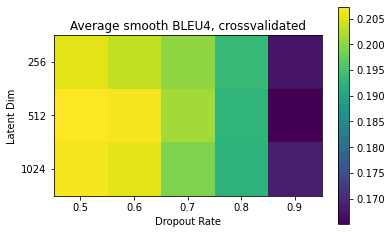

In [9]:
#Izvrsava se grid search nad hiperparametrima, i radi se unakrsna validacija za evaluaciju performansi
#Metrika nad kojom se vrsi selekcija je smooth BLEU4

metrics = cv_grid_search(df_train_val, dropout_rates, latent_dims, epochs = 200, learning_rate = learning_rate, folds = folds)
average_bleu4 = np.mean(metrics['smooth_bleu4'], axis = -1)

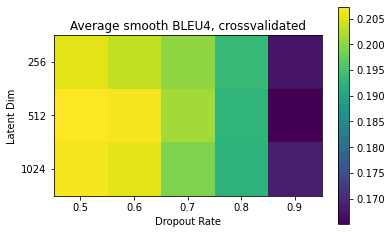

In [10]:
plt.title('Average smooth BLEU4, crossvalidated')
plt.xlabel('Dropout Rate')
plt.xticks(range(len(dropout_rates)), dropout_rates)
plt.ylabel('Latent Dim')
plt.yticks(range(len(latent_dims)),latent_dims)
plt.imshow(average_bleu4)
plt.colorbar()
plt.show()

In [11]:
best_config_index = np.unravel_index(np.argmax(average_bleu4), average_bleu4.shape)
best_latent_dim = latent_dims[best_config_index[0]]
best_dropout_rate = dropout_rates[best_config_index[1]]
print("Best latent dimension: ", best_latent_dim)
print("Best dropout rate: ", best_dropout_rate)

Best latent dimension:  512
Best dropout rate:  0.5


## Finalni model za evaluacija

Na kraju koristimo kombinovani trening i validacioni skup da istreniramo konacan model za evaluaciju.

Izdvajamo mali deo ovog skupa (300 redova) za validaciju tokom treniranja, da bismo znali kad da prekinemo trening.

In [12]:
df_train_val_np = df_train_val.to_numpy()
np.random.shuffle(df_train_val_np)
split_size = 300 
train_data = df_train_val_np[:train_size + val_size - split_size,]
val_data = df_train_val_np[train_size + val_size - split_size:,]
input_texts, target_texts = clean_texts(train_data[:,1], train_data[:,0])
input_word_index, target_word_index, max_input_seq_len, max_target_seq_len = analyse_texts(input_texts, target_texts)
input_pad_len = 80
target_pad_len = 60
num_input_words = len(input_word_index) - 1
num_target_words = len(target_word_index) - 1
inverted_input_word_index = {value: key for key,value in input_word_index.items()}
inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}
input_embedding_matrix, target_embedding_matrix = load_embedding_data_get_matrices(inverted_input_word_index, inverted_target_word_index)
encoder_input_data, decoder_input_data, decoder_output_data = create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len)

input_texts_val, target_texts_val = clean_texts(val_data[:,1], val_data[:,0])
encoder_input_data_val, decoder_input_data_val, decoder_output_data_val = create_model_data(input_texts_val, target_texts_val, input_word_index, target_word_index, input_pad_len, target_pad_len)

input_texts_test, target_texts_test = clean_texts_df(df_test)
encoder_input_data_test, decoder_input_data_test, decoder_output_data_test = create_model_data(input_texts_test, target_texts_test, input_word_index, target_word_index, input_pad_len, target_pad_len)

In [15]:
model_for_evaluation = Transformer_Translation_Model(num_input_words, num_target_words, input_embedding_matrix, target_embedding_matrix)

other_layers = model_for_evaluation.layers
embedding_layers = [] 
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers = [(Adam(learning_rate), other_layers), (Adam(learning_rate), embedding_layers)])
model_for_evaluation.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

early_stopping_safe = EarlyStopping(patience = 20, restore_best_weights = True, monitor = 'val_loss', mode = 'min', verbose = 1)
history = model_for_evaluation.fit([encoder_input_data, decoder_input_data], decoder_output_data, validation_data = ([encoder_input_data_val, decoder_input_data_val], decoder_output_data_val), epochs = 200, batch_size = 128, verbose = 1, callbacks = [early_stopping_safe])

Epoch 1/200
58/58 [==============================] - 11s 114ms/step - loss: 1.1862 - acc: 0.8313 - val_loss: 0.8253 - val_acc: 0.8517
Epoch 2/200
58/58 [==============================] - 4s 69ms/step - loss: 0.8300 - acc: 0.8564 - val_loss: 0.7314 - val_acc: 0.8666
Epoch 3/200
58/58 [==============================] - 3s 55ms/step - loss: 0.7781 - acc: 0.8633 - val_loss: 0.7246 - val_acc: 0.8675
Epoch 4/200
58/58 [==============================] - 3s 52ms/step - loss: 0.7550 - acc: 0.8656 - val_loss: 0.6864 - val_acc: 0.8730
Epoch 5/200
58/58 [==============================] - 3s 50ms/step - loss: 0.7217 - acc: 0.8688 - val_loss: 0.6483 - val_acc: 0.8768
Epoch 6/200
58/58 [==============================] - 3s 54ms/step - loss: 0.6886 - acc: 0.8720 - val_loss: 0.6117 - val_acc: 0.8806
Epoch 7/200
58/58 [==============================] - 3s 49ms/step - loss: 0.6485 - acc: 0.8775 - val_loss: 0.5612 - val_acc: 0.8892
Epoch 8/200
58/58 [==============================] - 3s 51ms/step - loss: 

In [17]:
model_for_evaluation.summary(expand_nested = True)

Model: "transformer__translation__model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 80, 300)           3683956   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_7 (InputLayer)       [(None, 80)]              0        |
|                                                               |
| custom_dropout_2 (CustomD  (None, 80)                0        |
| ropout)                                                       |
|                                                               |
| embedding_4 (Embedding)    (None, 80, 300)           641100   |
|                                                               |
| sine_position_encoding_4   (None, 80, 300)           0        |
| (SinePositionEncoding)                                        |
|                                                               |
| tf.__operators__.add_14 (  (Non

| ropout)                                                       |
|                                                               |
| embedding_4 (Embedding)    (None, 80, 300)           641100   |
|                                                               |
| sine_position_encoding_4   (None, 80, 300)           0        |
| (SinePositionEncoding)                                        |
|                                                               |
| tf.__operators__.add_14 (  (None, 80, 300)           0        |
| TFOpLambda)                                                   |
|                                                               |
| multi_head_attention_6 (M  (None, 80, 300)           2887500  |
| ultiHeadAttention)                                            |
|                                                               |
| tf.__operators__.add_15 (  (None, 80, 300)           0        |
| TFOpLambda)                                                   |
|         

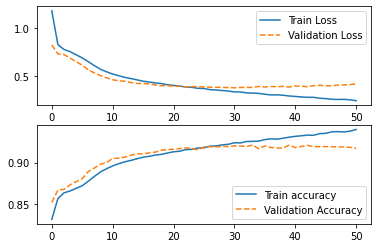

In [18]:
epoch_counter = range(len(history.history['loss']))
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(epoch_counter, history.history['loss'], label = 'Train Loss')
ax1.plot(epoch_counter, history.history['val_loss'], label = 'Validation Loss', linestyle = 'dashed')
ax1.legend()
ax2.plot(epoch_counter, history.history['acc'], label = 'Train accuracy')
ax2.plot(epoch_counter, history.history['val_acc'], label = 'Validation Accuracy', linestyle = 'dashed')
ax2.legend()

In [19]:
wer, smooth_bleu4, smooth_bleu3, smooth_bleu2, smooth_bleu1 = evaluate(model_for_evaluation, input_texts_test, target_texts_test, input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
print('Results on test data:')
print('Word Error Rate: ', 100*wer) 
print('BLEU4(smooth): ', 100*smooth_bleu4) 
print('BLEU3(smooth): ', 100*smooth_bleu3) 
print('BLEU2(smooth): ', 100*smooth_bleu2) 
print('BLEU1(smooth): ', 100*smooth_bleu1) 

Results on test data:
Word Error Rate:  59.86023799746276
BLEU4(smooth):  23.233016183449482
BLEU3(smooth):  31.929238219609495
BLEU2(smooth):  43.987826204885096
BLEU1(smooth):  58.085171428580495


In [20]:
n_examples = 3
starting_index = 38
translation_examples = translate_from_text(model_for_evaluation, input_texts_test[starting_index:starting_index + n_examples], input_word_index, target_word_index, inverted_target_word_index, input_pad_len, target_pad_len)
for i in range(n_examples):
    print('Originalna recenica:')
    print(input_texts_test[starting_index + i])
    print('Prevod:')
    print(translation_examples[i])
    print('Referenca:')
    print(target_texts_test[starting_index + i])
    print('\n')

Originalna recenica:
und nun die wettervorhersage für morgen dienstag den dreizehnten oktober
Prevod:
<Start> JETZT WETTER WIE-AUSSEHEN MORGEN DIENSTAG DREIZEHN OKTOBER 
Referenca:
<Start> JETZT MORGEN WETTER WIE - AUSSEHEN DREIZEHN OKTOBER <End>


Originalna recenica:
im westen ist es freundlich
Prevod:
<Start> WEST FREUNDLICH 
Referenca:
<Start> WEST FREUNDLICH <End>


Originalna recenica:
ähnliches wetter dann auch am donnerstag
Prevod:
<Start> DONNERSTAG GLEICH DONNERSTAG 
Referenca:
<Start> AUCH DONNERSTAG <End>


